In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [86]:
df_train = pd.read_csv('../train.csv',header = 0)

In [87]:
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40


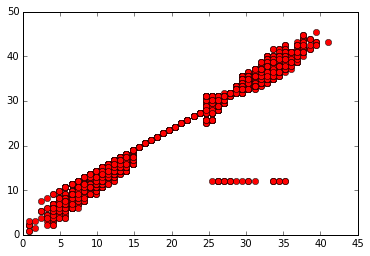

In [88]:
plt.plot(df_train['temp'],df_train['atemp'],'ro')
plt.show()

In [89]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df_train['temp'],df_train['atemp'])

In [90]:
print r_value**2

0.970122780341


In [91]:
mls = pd.DataFrame({'x': df_train['temp'],'y': df_train['humidity'],'a': df_train['windspeed'],'z' : df_train['atemp']})
model = ols("z ~ x + y + a", mls).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.249e+05
Date:                Fri, 28 Oct 2016   Prob (F-statistic):               0.00
Time:                        15:34:01   Log-Likelihood:                -19291.
No. Observations:               10886   AIC:                         3.859e+04
Df Residuals:                   10882   BIC:                         3.862e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.2438      0.071     31.424      0.0

In [92]:
anova_results = anova_lm(model)
print(anova_results)


             df         sum_sq        mean_sq              F         PR(>F)
x             1  758391.781110  758391.781110  374097.561502   0.000000e+00
y             1     327.847316     327.847316     161.719687   8.699755e-37
a             1     968.009513     968.009513     477.497261  1.241925e-103
Residual  10882   22060.607209       2.027257            NaN            NaN


In [93]:
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [94]:
df_train.shape

(10886, 12)

In [95]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour

In [96]:
df_train = df_train.drop(['datetime','casual','registered'], axis = 1)

In [97]:
df_train_target = df_train['count'].values
df_train_data = df_train.drop(['count'],axis = 1).values

In [98]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

In [99]:
cv = cross_validation.ShuffleSplit(len(df_train_data), n_iter=3, test_size=0.2,
    random_state=0)

print "SVR(kernel='rbf',C=10,gamma=.001)"
for train, test in cv:
    
    svc = svm.SVR(kernel ='rbf', C = 10, gamma = .001).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])))

print "Ridge"    
for train, test in cv:    
    svc = linear_model.Ridge().fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])))
    
print "Random Forest(n_estimators = 100)"    
for train, test in cv:    
    svc = RandomForestRegressor(n_estimators = 100).fit(df_train_data[train], df_train_target[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        svc.score(df_train_data[train], df_train_target[train]), svc.score(df_train_data[test], df_train_target[test])))

SVR(kernel='rbf',C=10,gamma=.001)
train score: 0.417, test score: 0.408

train score: 0.406, test score: 0.452

train score: 0.419, test score: 0.390

Ridge
train score: 0.339, test score: 0.332

train score: 0.330, test score: 0.370

train score: 0.342, test score: 0.320

Random Forest(n_estimators = 100)
train score: 0.982, test score: 0.864

train score: 0.981, test score: 0.880

train score: 0.981, test score: 0.871



In [100]:
X = df_train_data
y = df_train_target

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2, random_state=0)

tuned_parameters = [{'n_estimators':[10,100,500]}]   
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print ""
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""

r2
Best parameters set found on development set:

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Grid scores on development set:

0.850 (+/-0.006) for {'n_estimators': 10}
0.861 (+/-0.005) for {'n_estimators': 100}
0.863 (+/-0.005) for {'n_estimators': 500}



/usr/local/bin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


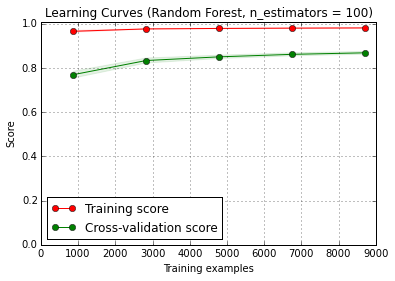

In [101]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Random Forest, n_estimators = 100)"
cv = cross_validation.ShuffleSplit(df_train_data.shape[0], n_iter=10,test_size=0.2, random_state=0)
estimator = RandomForestRegressor(n_estimators = 100)
plot_learning_curve(estimator, title, X, y, (0.0, 1.01), cv=cv, n_jobs=4)

plt.show()

In [102]:
model1 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False).fit(df_train_data[train], df_train_target[train])

In [110]:
pd.DataFrame(sorted(zip(df_train.columns.values,model1.feature_importances_),key=lambda a: a[1],reverse=True))

,0,1
0,day,0.588788
1,temp,0.079748
2,atemp,0.069159
3,humidity,0.060135
4,month,0.056479
5,workingday,0.041900
6,count,0.038050
7,windspeed,0.028623
8,weather,0.019655
9,season,0.014918


In [130]:
df_test1 = pd.read_csv('../test.csv',header = 0)
df_test = pd.read_csv('../test.csv',header = 0)
df_test['month'] = pd.DatetimeIndex(df_test.datetime).month
df_test['day'] = pd.DatetimeIndex(df_test.datetime).dayofweek
df_test['hour'] = pd.DatetimeIndex(df_test.datetime).hour
df_test = df_test.drop(['datetime'], axis = 1)

In [185]:
out = model1.predict(df_test)
pred = zip(df_test1['datetime'],out)

In [208]:
pred = pd.DataFrame({'datetime': np.array(pred)[:,0], 'count': np.array(pred)[:,1]})
pred = pred[['datetime','count']]

In [209]:
pred.to_csv("pred.csv", index = False, header = True)